# Import neccesary libraries :

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn

import math

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, auc, accuracy_score, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Load the Data :

In [2]:
df = pd.read_csv('Customer_Data.csv')
df.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


# Target Variable Distribution :

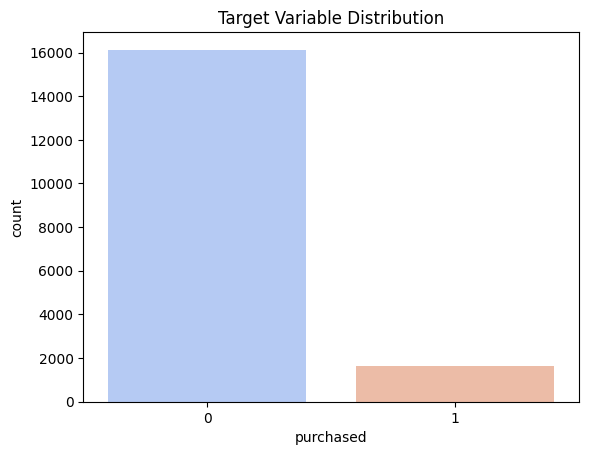

In [3]:
sns.countplot(x='purchased', data=df, palette='coolwarm')
plt.title('Target Variable Distribution')
plt.show()

# Visualize Outliers :

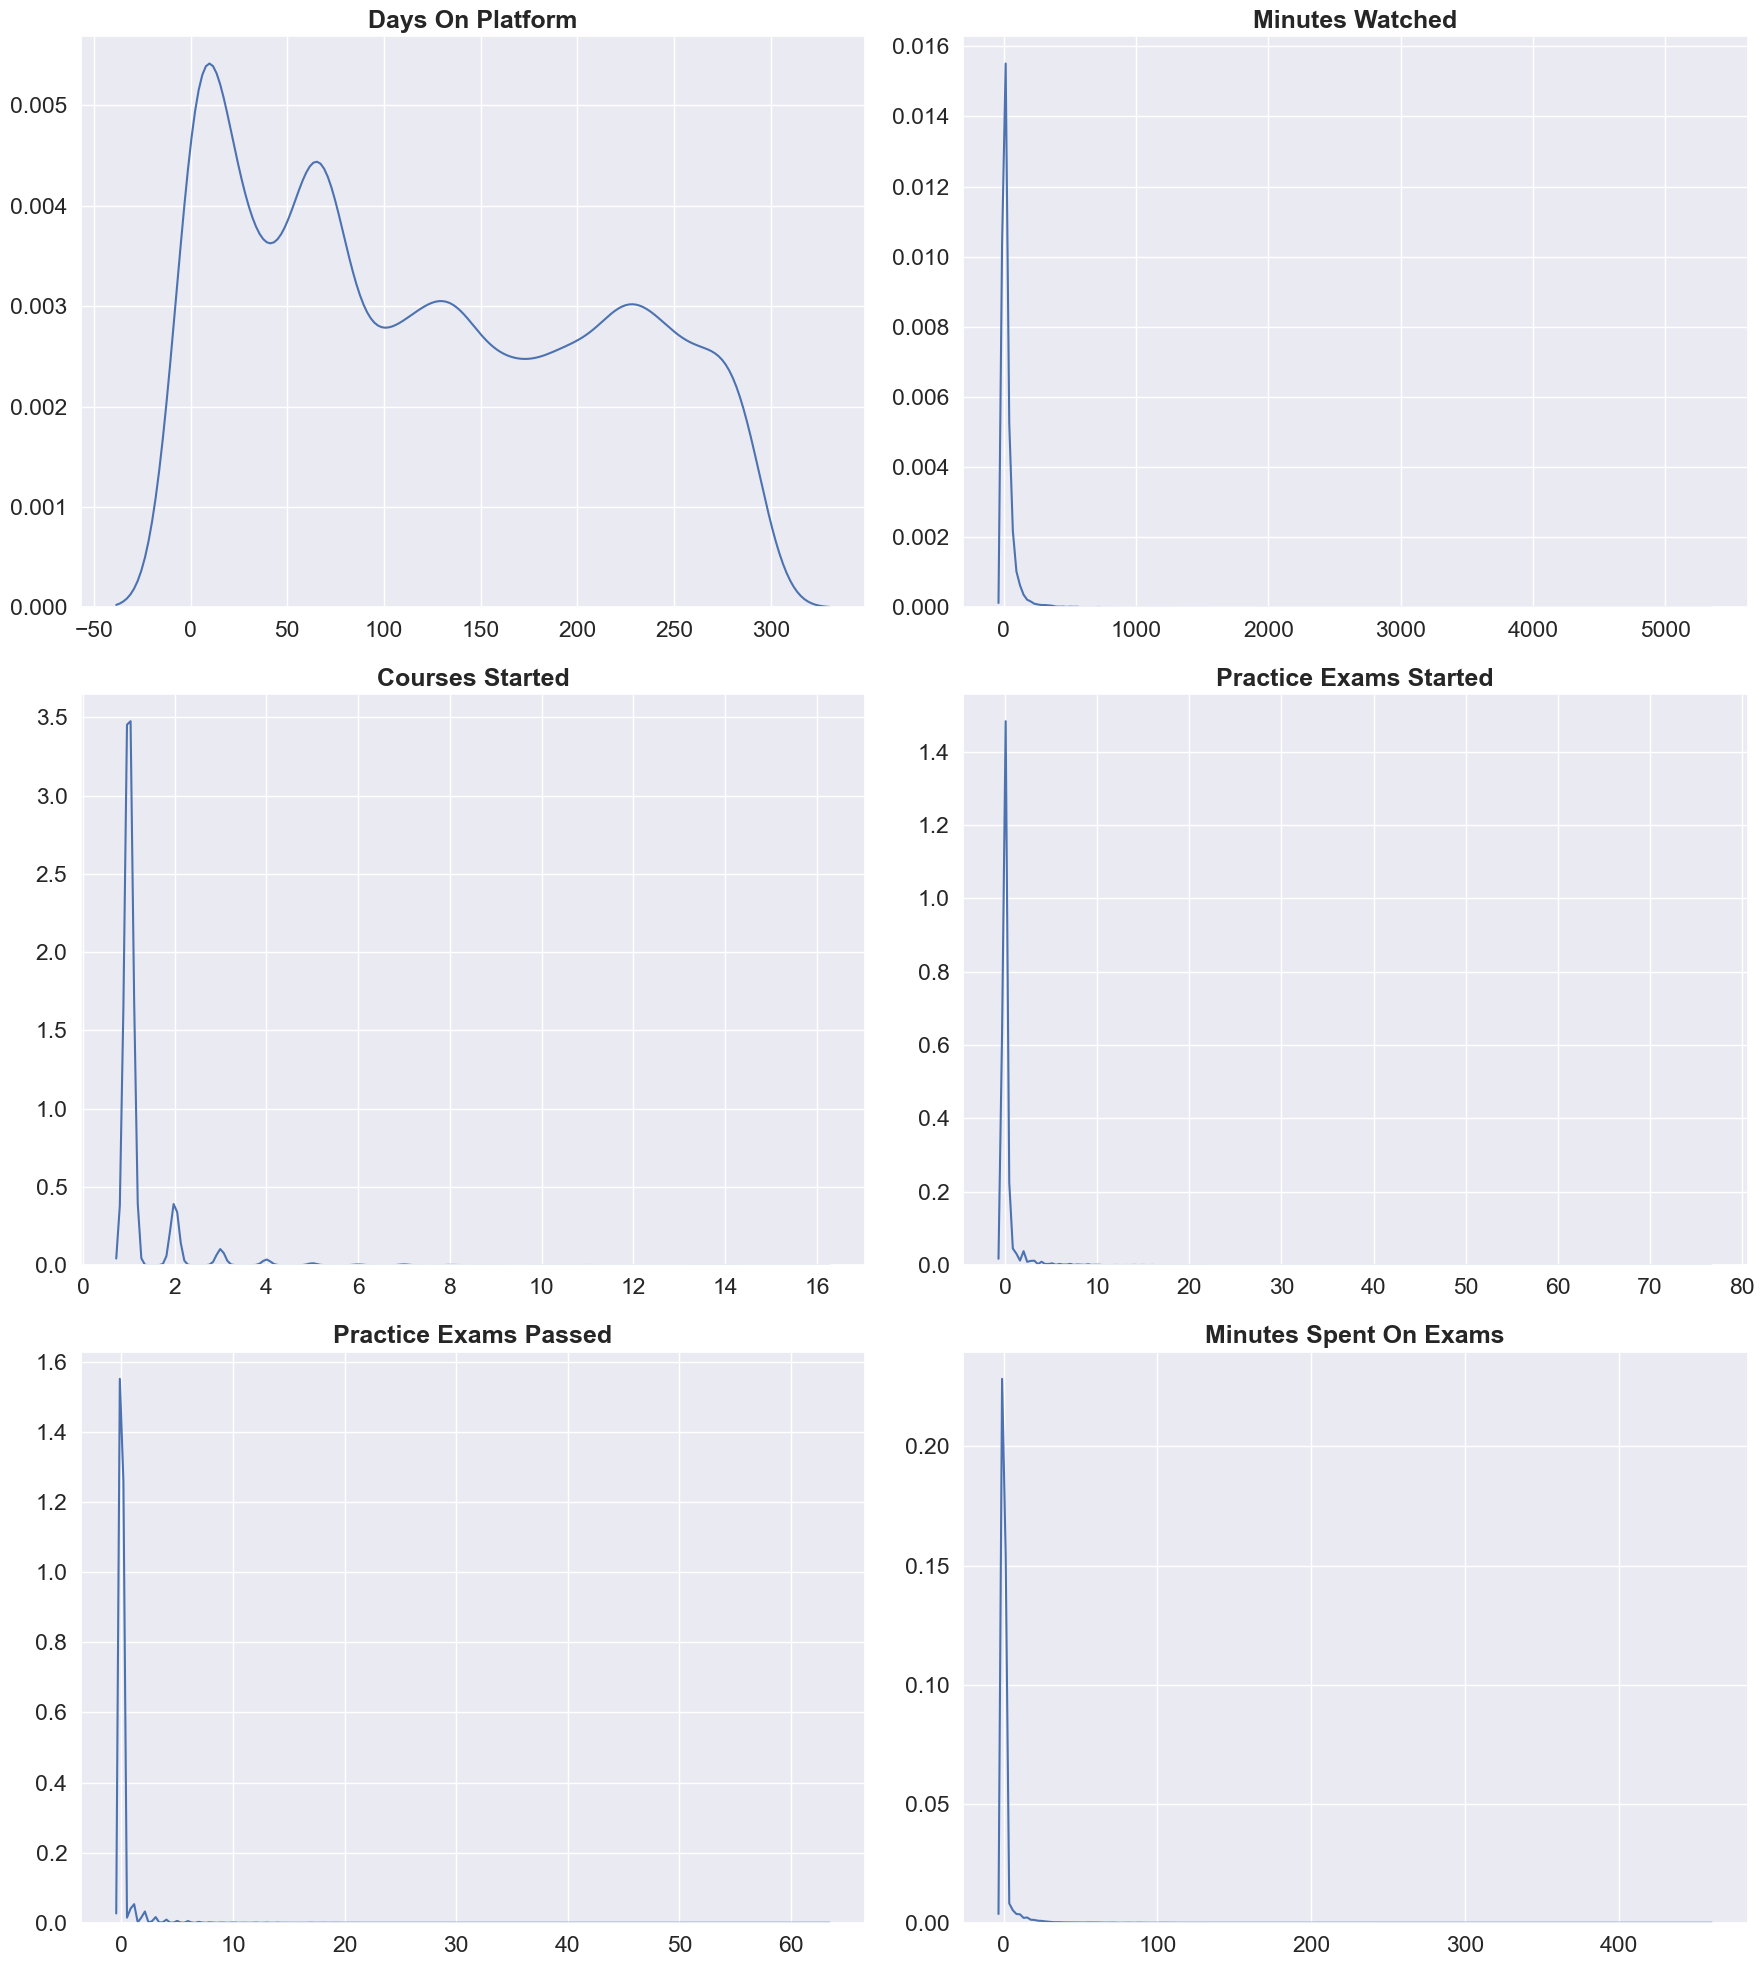

In [4]:
# Plot KDEs before removing outliers
sns.set(font_scale=1.5)
columns = ['days_on_platform', 'minutes_watched', 'courses_started',
           'practice_exams_started', 'practice_exams_passed', 'minutes_spent_on_exams']
n_cols = 2
n_rows = math.ceil(len(columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 20))
axes = axes.flatten()

for i, col in enumerate(columns):
    sns.kdeplot(data=df[col], ax=axes[i])
    axes[i].set_title(col.replace('_', ' ').title(), fontweight='bold', fontsize=18)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel(None)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Remove Outliers :

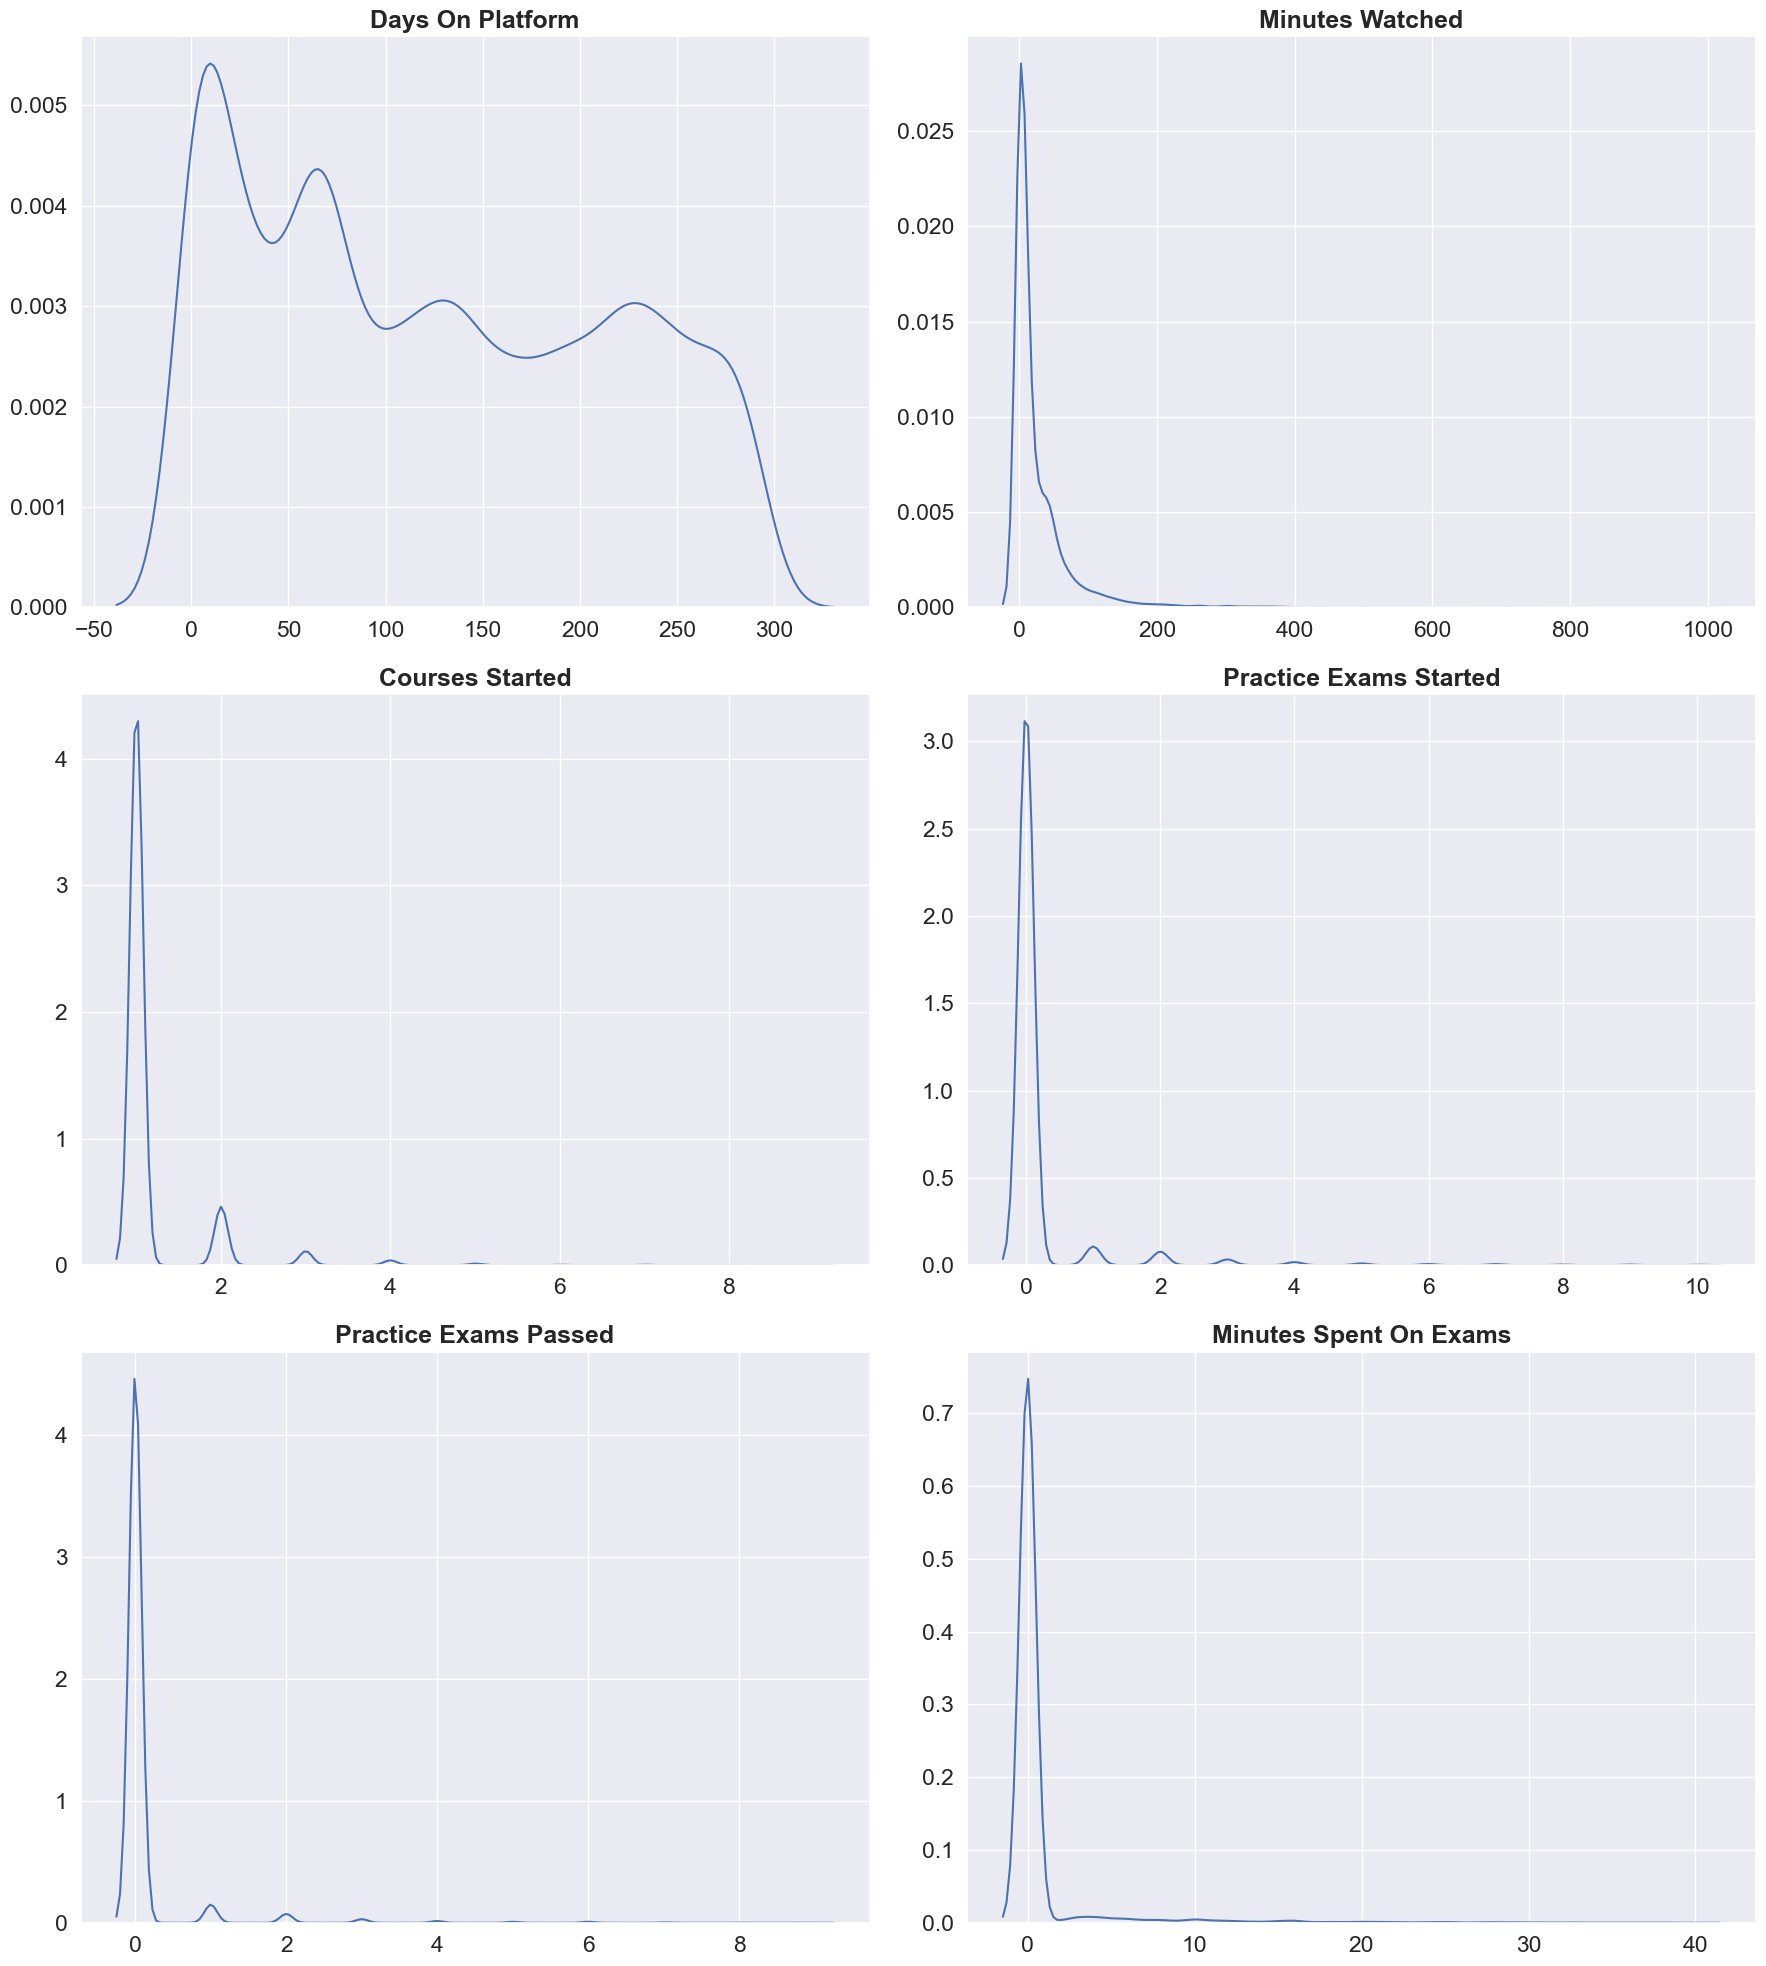

In [5]:
# Remove outliers
cleaned_df = df[(df['minutes_watched'] <= 1000) & (df['courses_started'] <= 10) &
                        (df['practice_exams_started'] <= 10) & (df['minutes_spent_on_exams'] <= 40)]

# Plot KDEs after removing outliers
columns = ['days_on_platform', 'minutes_watched', 'courses_started',
           'practice_exams_started', 'practice_exams_passed', 'minutes_spent_on_exams']
sns.set(font_scale=1.5)

n_cols = 2
n_rows = math.ceil(len(columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 20))
axes = axes.flatten()

for i, col in enumerate(columns):
    sns.kdeplot(data=cleaned_df[col], ax=axes[i])
    axes[i].set_title(col.replace('_', ' ').title(), fontweight='bold', fontsize=18)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel(None)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Correlation Heatmap :

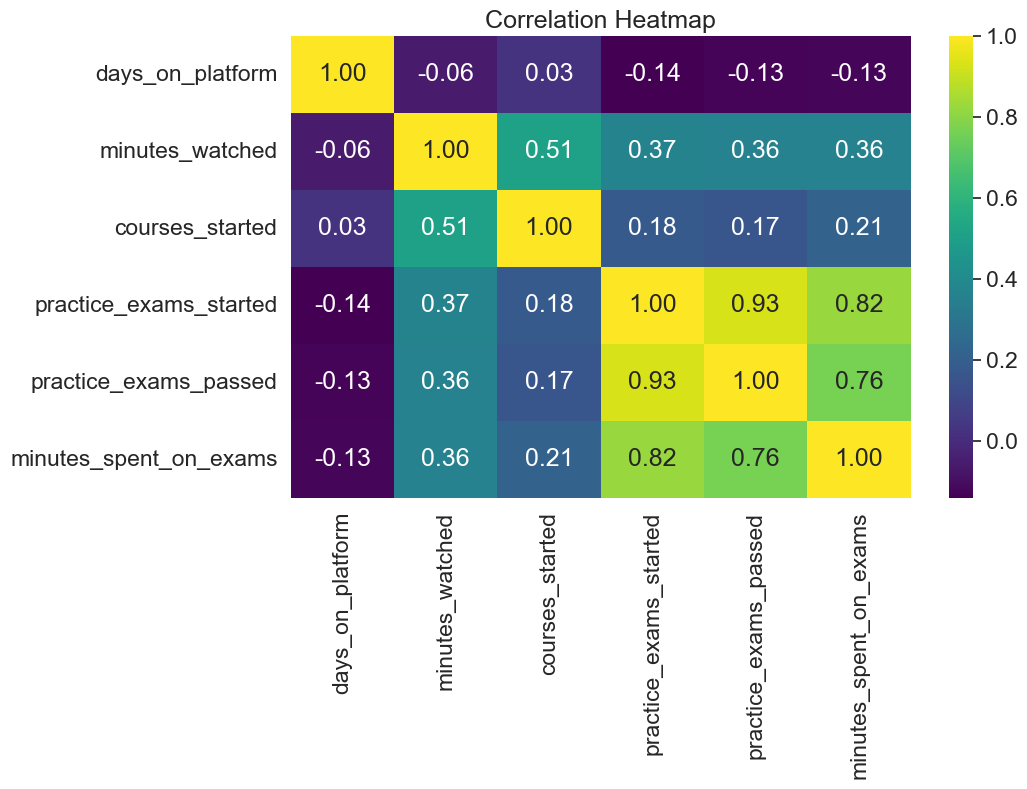

In [6]:
num_features = ['days_on_platform','minutes_watched','courses_started','practice_exams_started','practice_exams_passed','minutes_spent_on_exams']
plt.figure(figsize=(10,6))
sns.heatmap(cleaned_df[num_features].corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Handle Multicollinearity :

In [7]:
# Calculate and display the Variance Inflation Factor (VIF) for numerical variables
variables = cleaned_df[num_features]
vif_df = pd.DataFrame()
vif_df['VIF'] = [variance_inflation_factor(variables.to_numpy(), i) for i in range(variables.shape[1])]
vif_df['features'] = variables.columns
vif_df.sort_values('VIF', ascending=False, inplace=True)
vif_df.round(2)

,VIF,features
3,10.20,practice_exams_started
4,7.81,practice_exams_passed
5,3.35,minutes_spent_on_exams
2,3.18,courses_started
0,2.30,days_on_platform
1,1.79,minutes_watched


In [8]:
# Calculate and display VIF values after dropping a variable
reduced_df = cleaned_df.drop('practice_exams_started', axis=1)
num_features = ['days_on_platform','minutes_watched','courses_started','practice_exams_passed','minutes_spent_on_exams']

variables = reduced_df[num_features]
vif_df = pd.DataFrame()
vif_df['VIF'] = [variance_inflation_factor(variables.to_numpy(), i) for i in range(variables.shape[1])]
vif_df['features'] = variables.columns
vif_df.sort_values('VIF', ascending=False, inplace=True)
vif_df.round(2)

,VIF,features
2,3.17,courses_started
4,2.60,minutes_spent_on_exams
3,2.56,practice_exams_passed
0,2.30,days_on_platform
1,1.79,minutes_watched


# Handle Missing Values :

In [9]:
# Check for missing values in the dataset
reduced_df.isnull().sum()

student_country           8
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

In [10]:
# Find rows where the 'student_country' column has missing values
reduced_df.loc[reduced_df['student_country'].isna()]

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
311,NaN,88,58.1,1,2,11.20,1
337,NaN,86,43.0,1,2,12.96,0
556,NaN,121,241.9,2,3,21.29,0
806,NaN,64,86.4,1,2,4.98,0
1097,NaN,72,67.5,1,1,6.27,0
12363,NaN,84,6.2,1,0,0.00,0
12633,NaN,78,3.0,1,0,0.00,0
16946,NaN,11,8.2,1,0,0.00,0


In [11]:
# Replace missing values in 'student_country' with 'Unknown' and check the results
final_df = reduced_df.fillna('Unknown', axis=1)
final_df.loc[final_df['student_country'] == 'Unknown', 'student_country']

311      Unknown
337      Unknown
556      Unknown
806      Unknown
1097     Unknown
12363    Unknown
12633    Unknown
16946    Unknown
Name: student_country, dtype: object

# Splitting & Encoding Data :

In [12]:
# Split data into training and testing sets, stratified by the target variable 'purchased'
x = final_df.drop(['purchased'], axis=1)
y = final_df['purchased']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Encode 'student_country' using OrdinalEncoder and drop the original column from training and testing sets
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999)

x_train['student_country_enc'] = encoder.fit_transform(x_train[['student_country']])
x_test['student_country_enc'] = encoder.transform(x_test[['student_country']])

x_train = x_train.drop('student_country', axis=1)
x_test = x_test.drop('student_country', axis=1)

# Scale Features
scaler = MinMaxScaler(feature_range=(-1, 1))
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [13]:
# Convert the training and testing sets to NumPy arrays with appropriate data types
x_train_scaled = np.asarray(x_train_scaled, dtype='float')
y_train = np.asarray(y_train, dtype='int')

x_test_scaled = np.asarray(x_test_scaled, dtype='float')
y_test = np.asarray(y_test, dtype='int')

# 1. Logistic Regression Model :

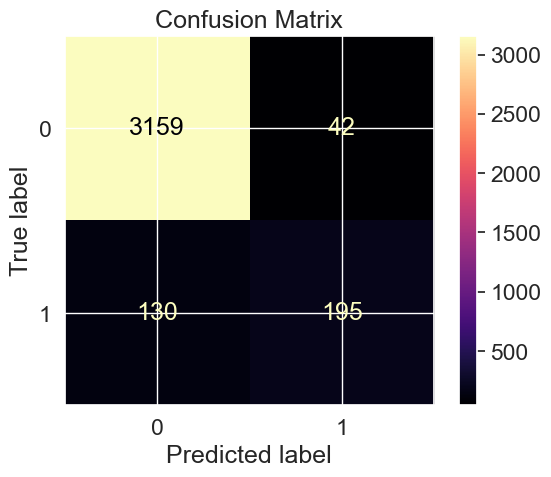

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3201
           1       0.82      0.60      0.69       325

    accuracy                           0.95      3526
   macro avg       0.89      0.79      0.83      3526
weighted avg       0.95      0.95      0.95      3526



In [14]:
params_logit = {
    'C': [0.01, 0.1, 1, 10],          
    'penalty': ['l2'],               
    'solver': ['lbfgs', 'saga']
}
logit_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
    params_logit,scoring='accuracy',cv=5)
logit_grid.fit(x_train_scaled, y_train)

logit_best = logit_grid.best_estimator_
logit_pred = logit_grid.predict(x_test_scaled)

ConfusionMatrixDisplay.from_predictions(y_test, logit_pred, cmap='magma')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, logit_pred))
logit_acc = accuracy_score(y_test, logit_pred)

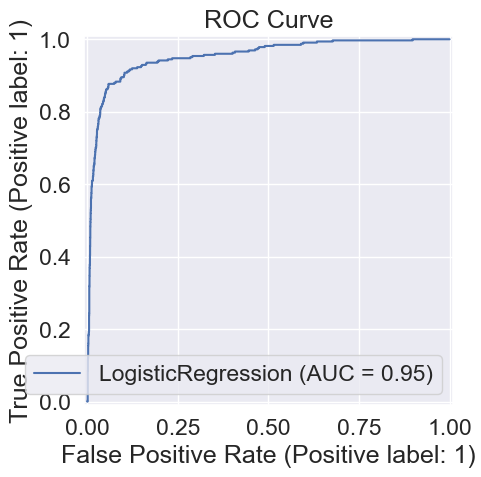

In [15]:
# ROC Curve
RocCurveDisplay.from_estimator(logit_best, x_test_scaled, y_test)
plt.title("ROC Curve")
plt.show()

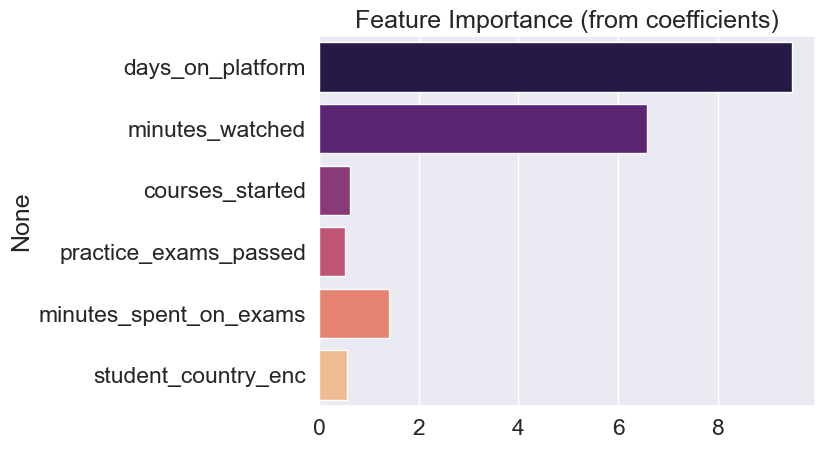

In [33]:
# Feature Importance 
importances = np.abs(logit_best.coef_[0])
sns.barplot(x=importances, y=x_train.columns, palette='magma') 
plt.title('Feature Importance (from coefficients)') 
plt.show()

# 2. K-Nearest Neighbors Model :

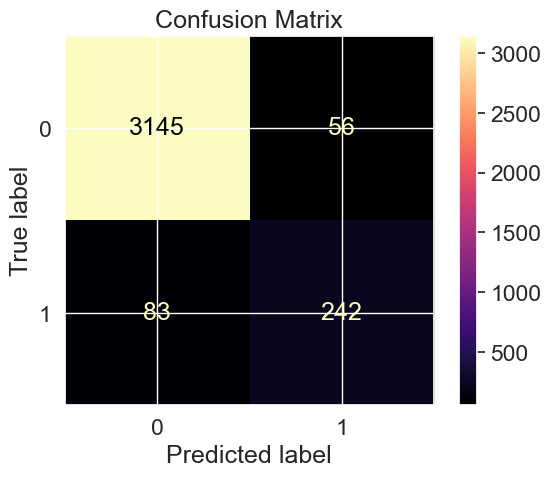

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3201
           1       0.81      0.74      0.78       325

    accuracy                           0.96      3526
   macro avg       0.89      0.86      0.88      3526
weighted avg       0.96      0.96      0.96      3526



In [18]:
params_knn = {'n_neighbors': range(1, 11), 
              'weights': ['uniform', 'distance'], 
              'metric': ['euclidean', 'manhattan']} 
knn_grid = GridSearchCV(KNeighborsClassifier(), params_knn, scoring='accuracy') 
knn_grid.fit(x_train_scaled, y_train) 

knn_best = knn_grid.best_estimator_ 
knn_pred = knn_best.predict(x_test_scaled) 

ConfusionMatrixDisplay.from_predictions(y_test, knn_pred, cmap='magma') 
plt.title('Confusion Matrix') 
plt.show() 

print(classification_report(y_test, knn_pred)) 
knn_acc = accuracy_score(y_test, knn_pred)

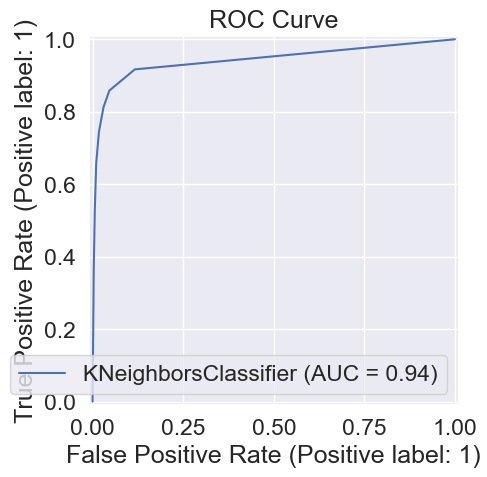

In [19]:
# ROC Curve 
RocCurveDisplay.from_estimator(knn_best, x_test_scaled, y_test)
plt.title("ROC Curve")
plt.show()

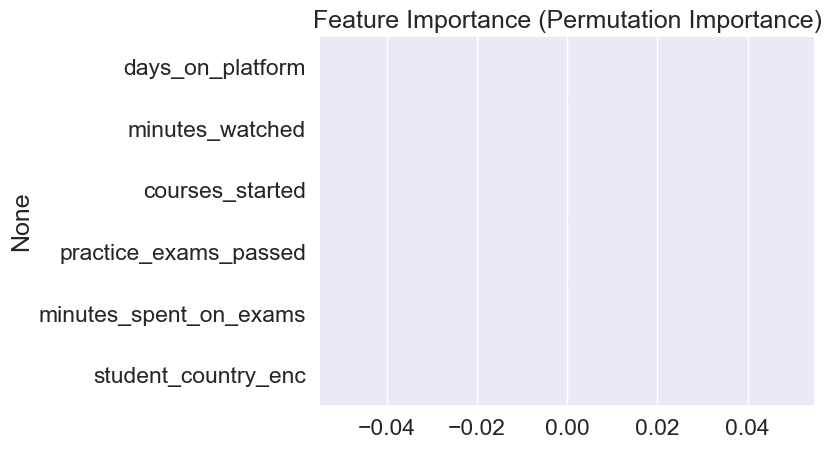

In [34]:
# Feature Importance 
from sklearn.inspection import permutation_importance
result = permutation_importance(knn_best, x_test, y_test, n_repeats=10, random_state=42)

importances = result.importances_mean
sns.barplot(x=importances, y=x_train.columns, palette='magma') 
plt.title('Feature Importance (Permutation Importance)') 
plt.show()

# 3. Support Vector Machine Model :

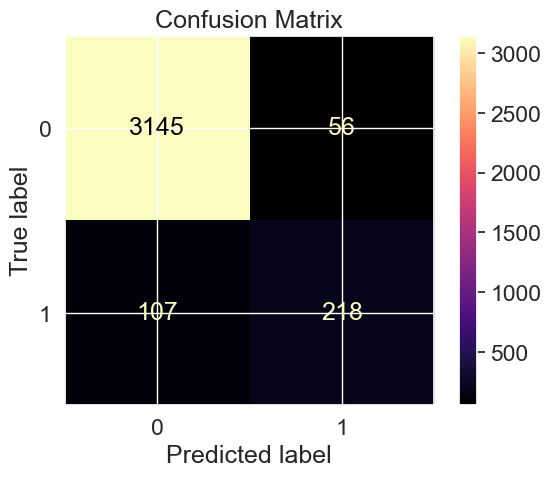

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3201
           1       0.80      0.67      0.73       325

    accuracy                           0.95      3526
   macro avg       0.88      0.83      0.85      3526
weighted avg       0.95      0.95      0.95      3526



In [22]:
params_svm = {'kernel': ['linear', 'poly', 'rbf'], 
              'gamma': ['scale', 'auto'], 
              'C': range(1, 6)} 
svm_grid = GridSearchCV(SVC(random_state=42), params_svm, scoring='accuracy',cv=5) 
svm_grid.fit(x_train_scaled, y_train) 

svm_best = svm_grid.best_estimator_ 
svm_pred = svm_best.predict(x_test_scaled) 

ConfusionMatrixDisplay.from_predictions(y_test, svm_pred, cmap='magma') 
plt.title('Confusion Matrix') 
plt.show() 

print(classification_report(y_test, svm_pred))
svm_acc = accuracy_score(y_test, svm_pred)

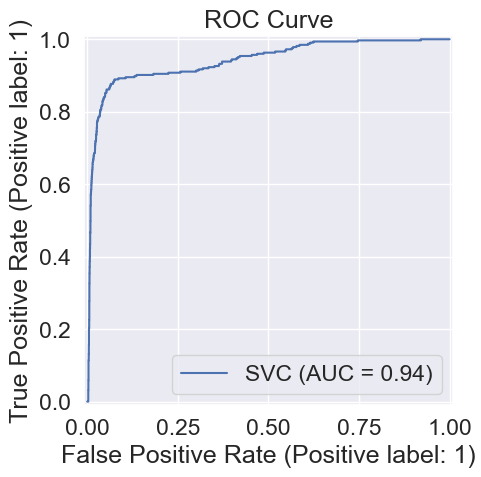

In [23]:
# ROC Curve
RocCurveDisplay.from_estimator(svm_best, x_test_scaled, y_test)
plt.title("ROC Curve")
plt.show()

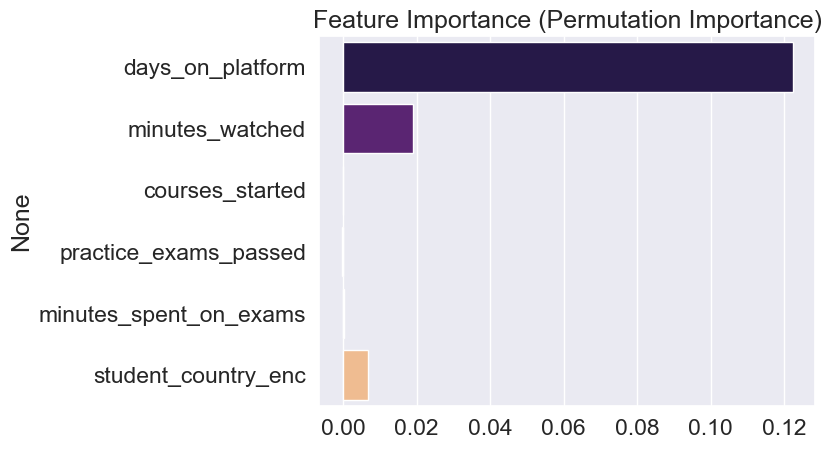

In [35]:
# Feature Importance 
result = permutation_importance(svm_best, x_test, y_test, n_repeats=10, random_state=42)

importances = result.importances_mean 
sns.barplot(x=importances, y=x_train.columns, palette='magma') 
plt.title('Feature Importance (Permutation Importance)') 
plt.show()

# 4. Decision Tree Model :

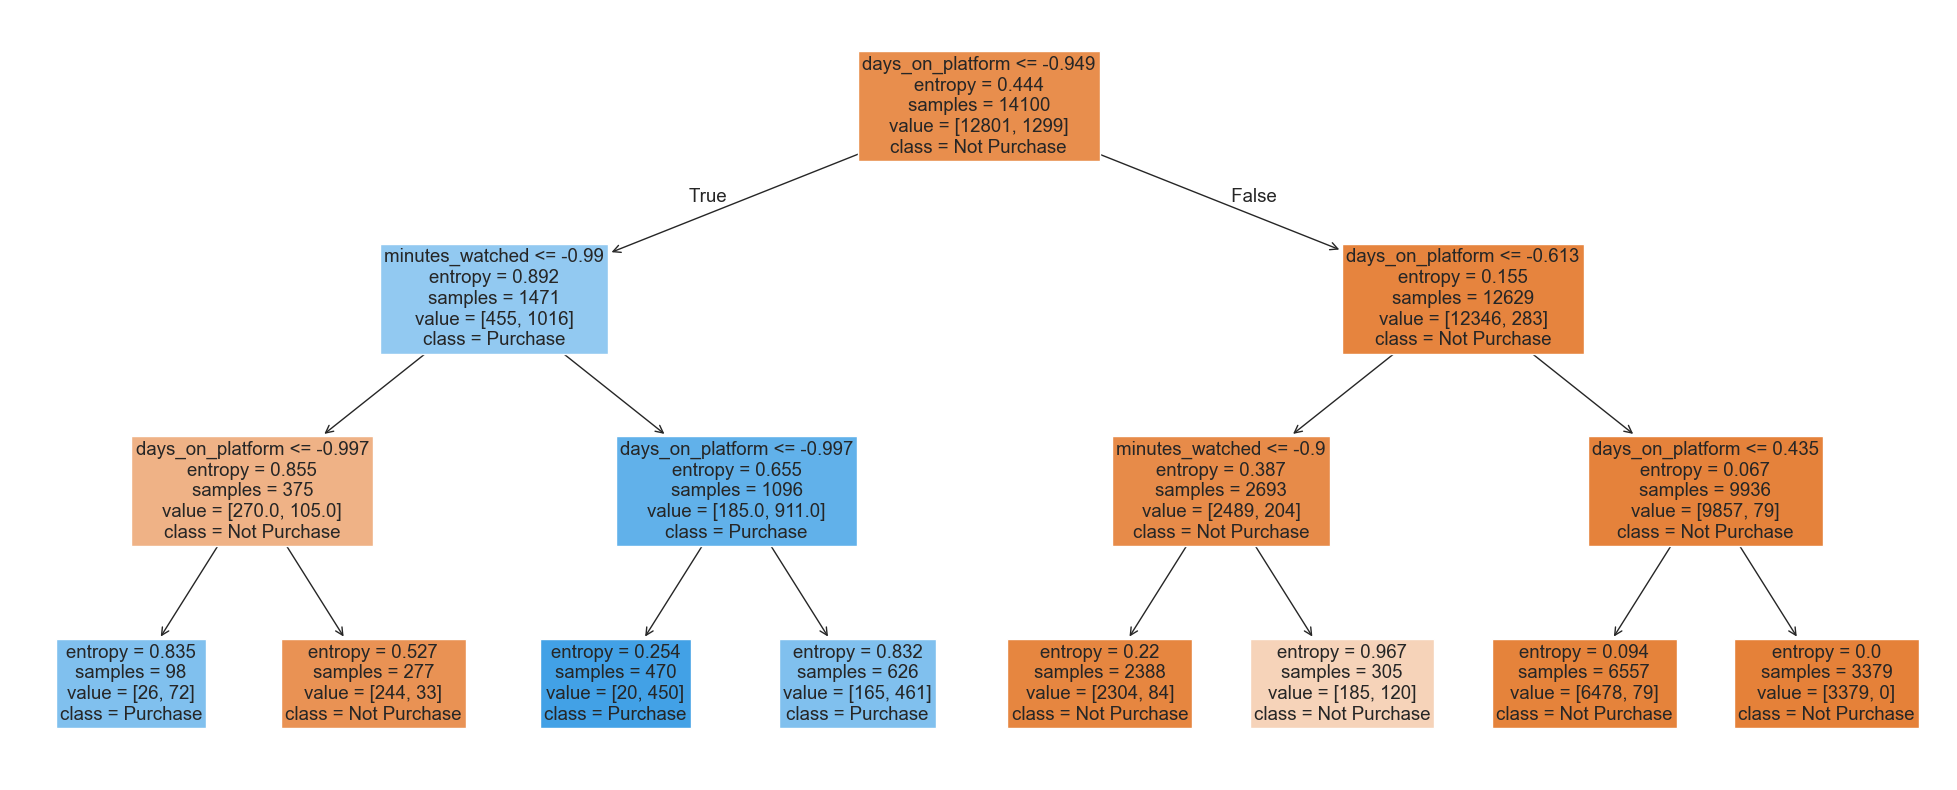

In [26]:
params_dt = {'criterion': ['gini', 'entropy'], 
             'max_depth': [None, 2, 3, 5], 
             'min_samples_split': [2, 5, 10], 
             'min_samples_leaf': [1, 2, 4]} 
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), params_dt, scoring='accuracy',cv=5) 
dt_grid.fit(x_train_scaled, y_train) 

dt_best = dt_grid.best_estimator_ 
dt_pred = dt_best.predict(x_test_scaled)

plt.figure(figsize=(25,10)) 
plot_tree(dt_best, filled=True, feature_names=x_train.columns, class_names=['Not Purchase','Purchase']) 
plt.show()

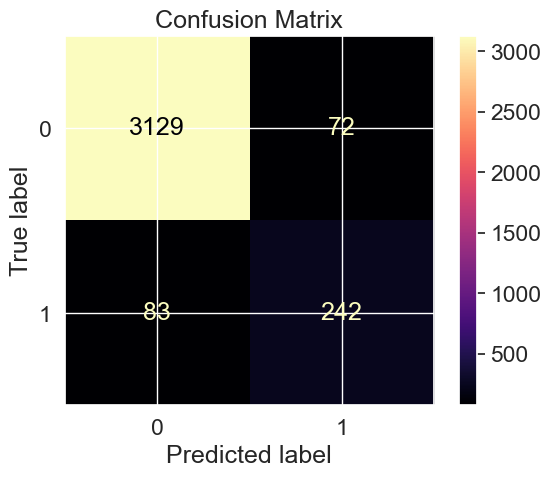

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3201
           1       0.77      0.74      0.76       325

    accuracy                           0.96      3526
   macro avg       0.87      0.86      0.87      3526
weighted avg       0.96      0.96      0.96      3526



In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, dt_pred, cmap='magma') 
plt.title('Confusion Matrix') 
plt.show() 

print(classification_report(y_test, dt_pred))
dt_acc = accuracy_score(y_test, dt_pred)

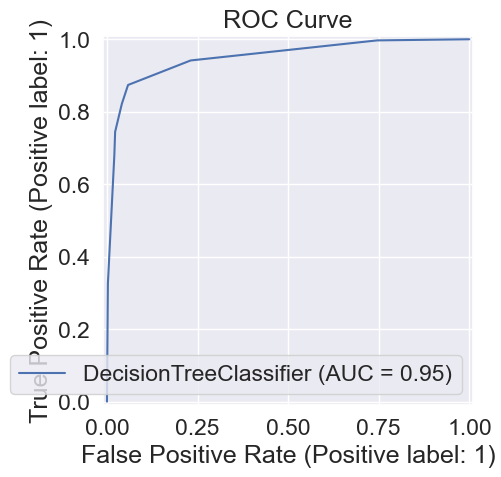

In [28]:
# ROC Curve 
RocCurveDisplay.from_estimator(dt_best, x_test_scaled, y_test)
plt.title("ROC Curve")
plt.show()

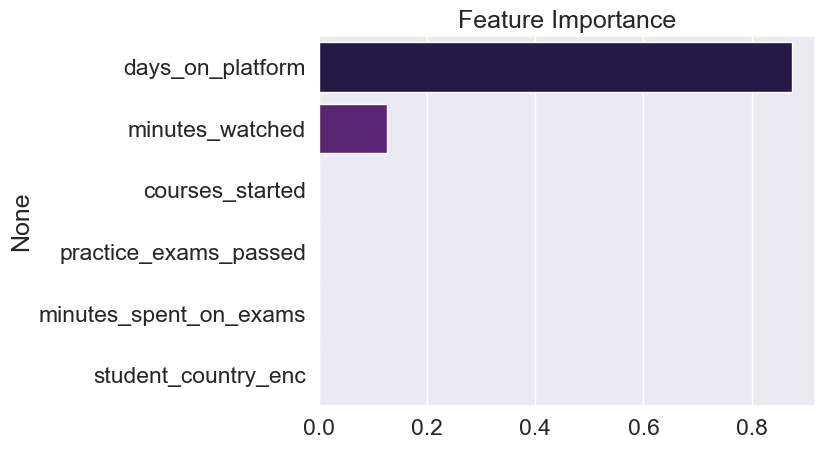

In [29]:
# Feature Importance 
importances = dt_best.feature_importances_ 
sns.barplot(x=importances, y=x_train.columns, palette='magma') 
plt.title('Feature Importance') 
plt.show()

# 5. Random Forest Model :

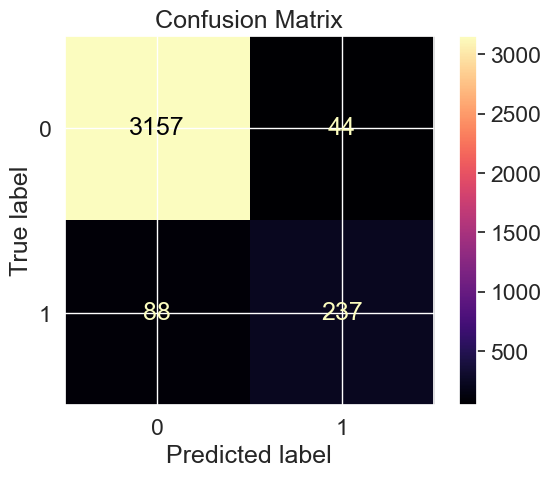

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3201
           1       0.84      0.73      0.78       325

    accuracy                           0.96      3526
   macro avg       0.91      0.86      0.88      3526
weighted avg       0.96      0.96      0.96      3526



In [30]:
params_rf = {'max_features': ['sqrt', 'log2'], 
             'n_estimators': [100, 200], 
             'max_depth': [5, 10, None], 
             'min_samples_split': [2, 5], 
             'min_samples_leaf': [1, 2]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), params_rf, scoring='accuracy') 
rf_grid.fit(x_train_scaled, y_train) 

rf_best = rf_grid.best_estimator_ 
rf_pred = rf_best.predict(x_test_scaled)

ConfusionMatrixDisplay.from_predictions(y_test, rf_pred, cmap='magma') 
plt.title('Confusion Matrix') 
plt.show() 

print(classification_report(y_test, rf_pred))
rf_acc = accuracy_score(y_test, rf_pred)

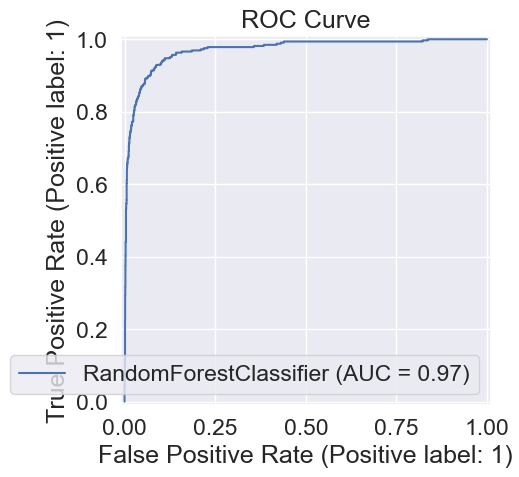

In [31]:
# ROC Curve
RocCurveDisplay.from_estimator(rf_best, x_test_scaled, y_test)
plt.title("ROC Curve")
plt.show()

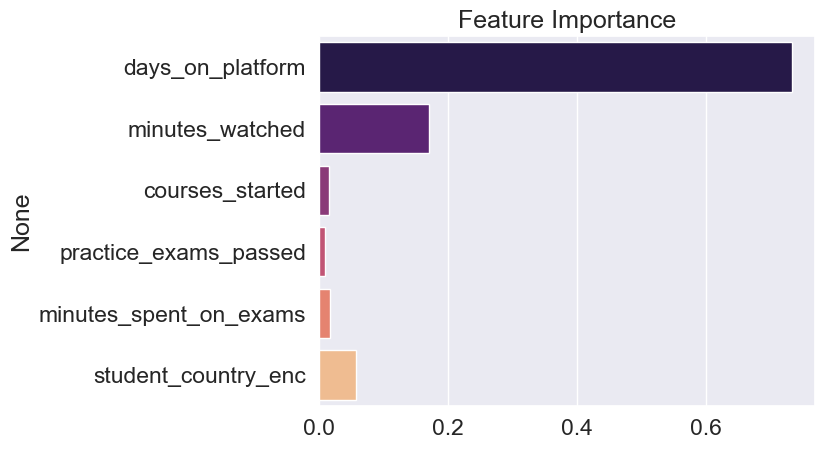

In [32]:
# Feature Importance 
importances = rf_best.feature_importances_ 
sns.barplot(x=importances, y=x_train.columns, palette='magma') 
plt.title('Feature Importance') 
plt.show()

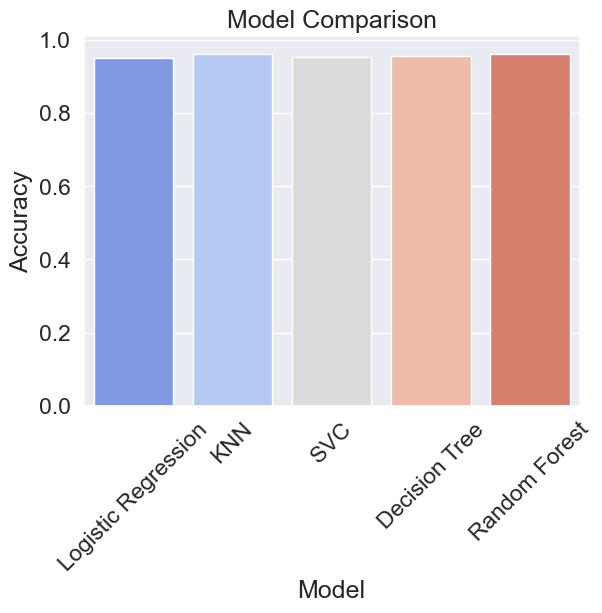

                 Model  Accuracy
0  Logistic Regression  0.951220
1                  KNN  0.960579
2                  SVC  0.953772
3        Decision Tree  0.956041
4        Random Forest  0.962564


In [37]:
# Final Model Comparison

results = pd.DataFrame({ 'Model': ['Logistic Regression', 'KNN', 'SVC', 'Decision Tree', 'Random Forest'], 
                        'Accuracy': [logit_acc, knn_acc, svm_acc, dt_acc, rf_acc] })

sns.barplot(x='Model', y='Accuracy', data=results, palette='coolwarm') 
plt.title('Model Comparison') 
plt.xticks(rotation=45) 
plt.show()

print(results)

In [42]:
import pickle

with open('model.pkl','wb') as file :
    pickle.dump(rf_best,file)

with open('encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [41]:
print("Numpy",np.__version__)
print("Pandas",pd.__version__)
print("Sklearn",sklearn.__version__)

Numpy 2.1.3
Pandas 2.2.3
Sklearn 1.6.1


In [49]:
import pandas as pd

# Pick a country from your data or test input
test_country = final_df['student_country'].iloc[0]  # or any value

# Encode using the fitted encoder without changing original column
test_country_enc = encoder.transform(pd.DataFrame({'student_country':[test_country]}))[0][0]

print("Original country:", test_country)
print("Encoded value:", test_country_enc)

Original country: TR
Encoded value: 146.0
